# GRU Multivariate Time Series Modeling to Predict Salamander Population

In [4]:
import pandas as pd

temperature_df = pd.read_excel('dataset/Temp_SRS_1Jan1964_to_31Oct2020.xlsx')
rainfall_df = pd.read_csv('dataset/Rainfall_at_SRS_30Nov1960_to_18Nov2020.csv')
salamander_df = pd.read_excel('dataset/RB-GBdataForAImodel.xlsx')

salamander_df['Date'] = salamander_df['Date'].astype(str)
salamander_df.loc[salamander_df['Date'].str.startswith('1'), 'Date'] = salamander_df['Date'].str.replace('1', '20', 1)
salamander_df.loc[~salamander_df['Date'].str.startswith('20'), 'Date'] = '19' + salamander_df['Date']
salamander_df = salamander_df.rename(columns={'Date': 'DATE'})
salamander_df = salamander_df.query("Site == 'RB'")
salamander_df.head()

rainfall_df = rainfall_df.fillna(0)

temperature_df['DATE'] = pd.to_datetime(temperature_df['DATE'], format='%Y-%m-%d')
rainfall_df['DATE'] = pd.to_datetime(rainfall_df['DATE'], format='%m/%d/%Y')
salamander_df['DATE'] = pd.to_datetime(salamander_df['DATE'], format='%Y%m%d')

total_salamander_pop_df = salamander_df.groupby(salamander_df['DATE'].dt.date)["Number"].sum().reset_index()
total_salamander_pop_df.DATE = pd.to_datetime(total_salamander_pop_df.DATE, format='%Y-%m-%d')
total_salamander_pop_df.head()

rain_temp_df = pd.merge(temperature_df, rainfall_df, on='DATE', how="outer")
rain_temp_salamander_df = pd.merge(rain_temp_df, total_salamander_pop_df, on='DATE', how="outer")
rain_temp_salamander_df = rain_temp_salamander_df.rename(columns={'LOW TEMP': 'MIN_TEMP', 'HIGH TEMP': 'MAX_TEMP', '200-F Rainfall (inches/day)': 'RAINFALL', 'Number': 'POPULATION'})
start_date = '1979-09-17'
end_date = '2020-10-31'
rain_temp_salamander_df = rain_temp_salamander_df.query("DATE >= @start_date and DATE <= @end_date")
# the dates above are selected because salamander data are available only from 1979-09-17 and the temperature data are available only till 2020-10-31
rain_temp_salamander_df['POPULATION'].fillna(0, inplace=True)
rain_temp_salamander_df['RAINFALL'].fillna(0, inplace=True)

rain_temp_salamander_df = rain_temp_salamander_df.set_index('DATE')

In [5]:
time_shift = 1

target_data = rain_temp_salamander_df['POPULATION'].shift(time_shift)
data = rain_temp_salamander_df.iloc[:-time_shift]

test_head = data.index[int(0.8 * len(data))]

df_train = rain_temp_salamander_df.loc[:test_head, :]
df_test = rain_temp_salamander_df.loc[test_head:, :]

target_train = target_data.loc[:test_head]
target_test = target_data.loc[test_head:]

target_train = target_train.fillna(0)

In [6]:
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

sequence_length = 30
features = ['MIN_TEMP', 'MAX_TEMP', 'RAINFALL', 'POPULATION']
target = ['POPULATION']
batch_size = 32
hidden_size = 8
learning_rate = 0.0001
input_size = len(features)
num_layers = 1
output_size = len(target)
num_epochs = 100
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))
class SequenceDataset(Dataset):
    def __init__(self, df, target, features, scaler, target_scaler, sequence_length = 5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.scaler = scaler
        self.target_scaler = target_scaler
        self.y = torch.tensor(self.target_scaler.fit_transform(df[target].values)).float()
        self.X = torch.tensor(self.scaler.fit_transform(df[features].values)).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            item_start = i - self.sequence_length + 1
            x = self.X[item_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0: (i + 1), :]
            x = torch.cat((padding, x), 0)
        return x, self.y[i]

train_dataset = SequenceDataset(df_train, target, features, scaler, target_scaler, sequence_length)
test_dataset = SequenceDataset(df_test, target, features, scaler, target_scaler, sequence_length)

datasets = {
    'train': train_dataset,
    'test': test_dataset
}

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=False)
}

class GRUModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_size, 16)
        self.fc2 = torch.nn.Linear(16, output_size)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # Initialize the hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, hn = self.gru(x, h0)
        hn = hn.view(-1, self.hidden_size)

        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out

def train_model(model, criterion, optimizer, tensorboard, num_epochs = 3):
    for epoch in tqdm(range(num_epochs)):
        for phase in ['train', 'test']:
            running_loss = 0.0
            running_mae = 0.0
            running_rmse = 0.0

            if phase == 'train':
                model.train()
                for i, data in enumerate(dataloaders[phase]):
                    X_batch, y_batch = data
                    y_pred = model(X_batch)
                    loss = criterion(y_pred, y_batch)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    running_mae += torch.abs(y_pred - y_batch).sum().item()
                    running_rmse += torch.sqrt(torch.pow(y_pred - y_batch, 2).sum()).item()
            else:
                model.eval()
                with torch.no_grad():
                    for i, data in enumerate(dataloaders[phase]):
                        X_batch, y_batch = data

                        y_pred = model(X_batch)
                        loss = criterion(y_pred, y_batch)

                        running_loss += loss.item()
                        running_mae += torch.abs(y_pred - y_batch).sum().item()
                        running_rmse += torch.sqrt(torch.pow(y_pred - y_batch, 2).sum()).item()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_mae = running_mae / len(datasets[phase])
            epoch_rmse = running_rmse / len(datasets[phase])

            tensorboard.add_scalar(f"Loss during {phase}", epoch_loss, epoch)
            tensorboard.add_scalar(f"MAE during {phase}", epoch_mae, epoch)
            tensorboard.add_scalar(f"RMSE during {phase}", epoch_rmse, epoch)
    tensorboard.close()

model = GRUModel(input_size, hidden_size, num_layers, output_size)
tensorboard = SummaryWriter()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, tensorboard, num_epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\lagesr\AppData\Local\Temp\ipykernel_18288\1556403429.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[pred_column] = predict(dataloaders['test'], model)


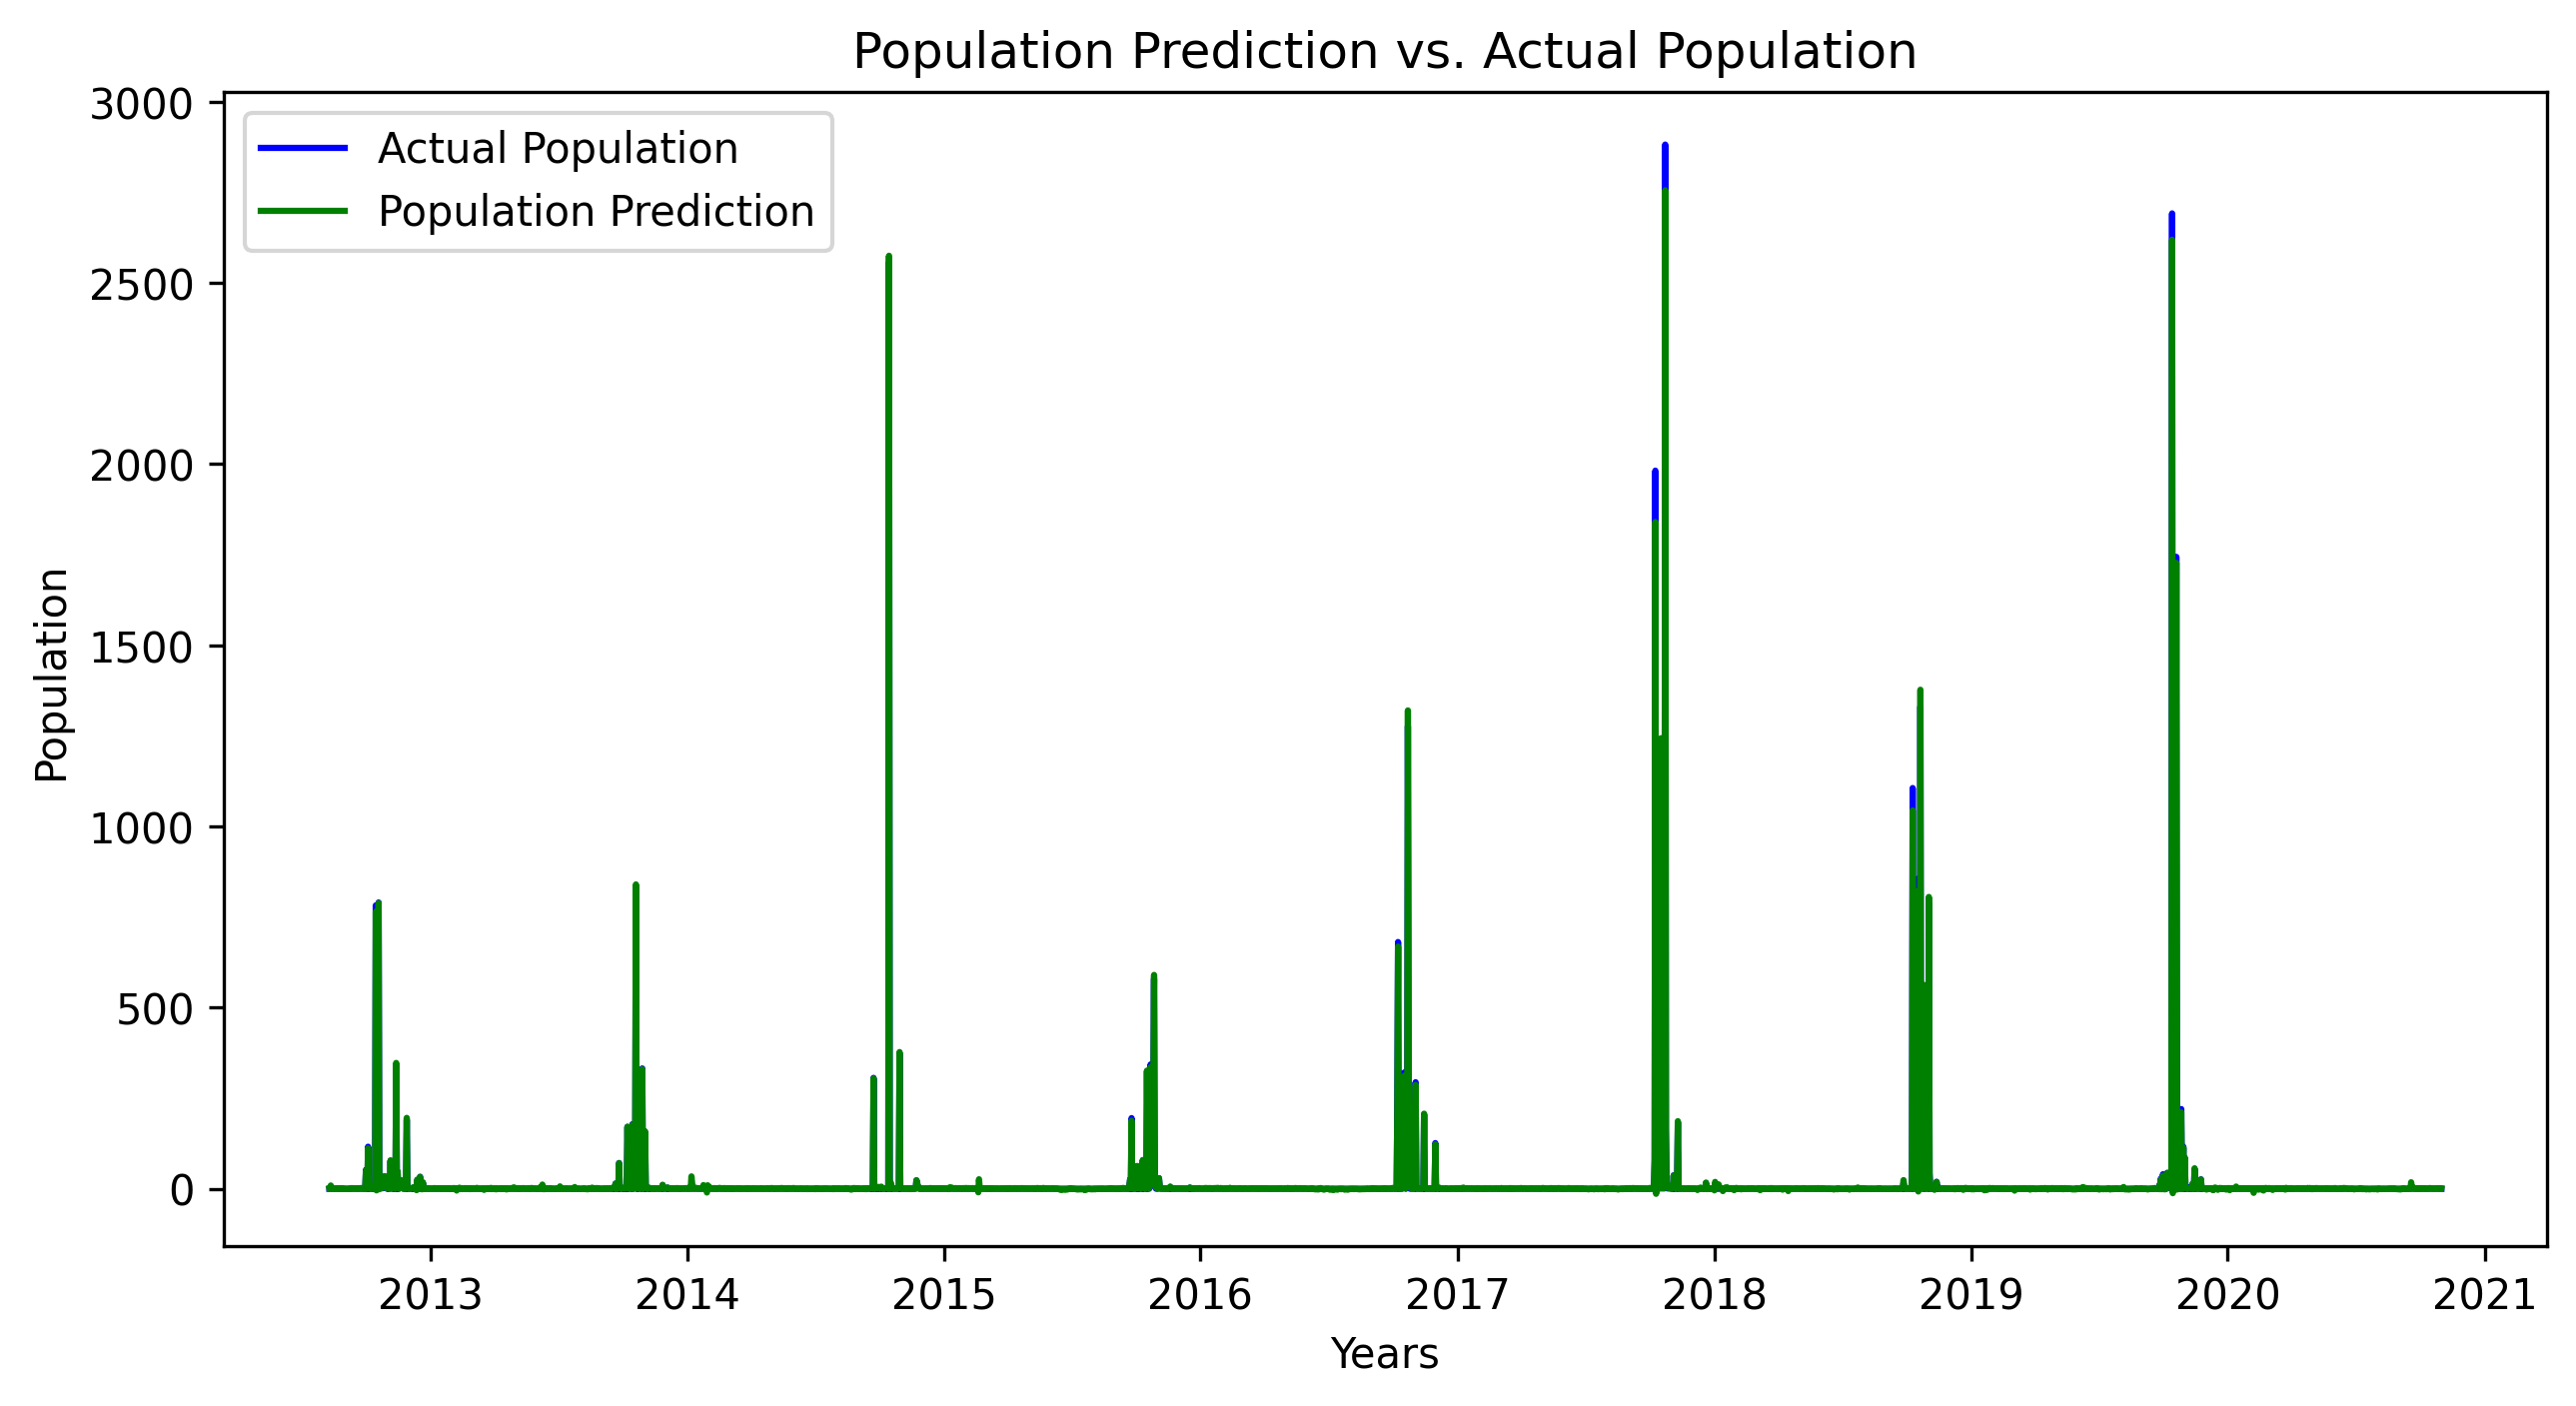

In [7]:
import numpy as np
def predict(dataloader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            X_batch, y_batch = data
            y_pred = model(X_batch)
            output = torch.cat((output, y_pred), 0)
    output = target_scaler.inverse_transform(np.array(output))
    return output

pred_column = 'Population Prediction'
df_test[pred_column] = predict(dataloaders['test'], model)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5), dpi=300)
plt.xlabel('Years')
plt.ylabel('Population')
plt.title('Population Prediction vs. Actual Population')
plt.plot(df_test[target[0]], color='blue', label='Actual Population')
plt.plot(df_test[pred_column], color='green', label='Population Prediction')
plt.legend()
plt.show()